In [1]:
import yfinance as yf

In [2]:
sp500 = yf.Ticker("^GSPC")

In [3]:
sp500 = sp500.history(period="max")

<Axes: xlabel='Date'>

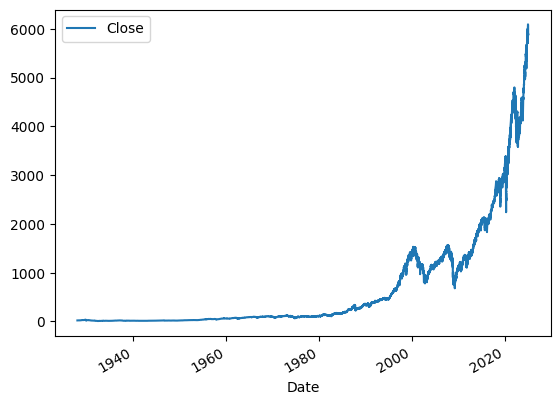

In [8]:
sp500.plot.line(y="Close", use_index=True)

In [9]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [10]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [14]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [16]:
sp500 = sp500.loc["1990-01-01":].copy()

In [19]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [23]:
from sklearn.metrics import precision_score
import pandas as pd

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6896551724137931

In [24]:
combined = pd.concat([test["Target"], preds], axis=1)

In [27]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [28]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [29]:
predictions = backtest(sp500, model, predictors)

In [31]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5282947208507406

In [32]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.535856
0,0.464144


In [33]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]

In [35]:
sp500 = sp500.dropna()

In [37]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [38]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [39]:
predictions = backtest(sp500, model, new_predictors)

In [40]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5720984759671747